In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pair_signrank(x, axis=0):
    import scipy.stats as ss
    if axis!=0:
        x = x.T
    p_list = np.empty(x.shape[0]-1)
    for n in range(x.shape[0]-1):
        t, p = ss.wilcoxon(x[n,:], x[n+1,:], zero_method='zsplit')
        # print(f'T-value: {t}, p-value: {p}')
        p_list[n] = p
    return p_list

In [3]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
include_inds = np.array([4, 5, 11, 12, 13, 14, 22, 31, 32, 33, 34, 38, 39, 43, 52, 54])

In [4]:
from scipy.signal import medfilt
row = dat_xls_file.iloc[include_inds[0]]
folder = row['folder']
fish = row['fish']
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.median(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
time_swim = dff.shape[1] - frame_swim_tcourse[0].shape[0]
time_dff = dff.shape[1] - spk.shape[1]

In [5]:
subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
gauss_rate = gaussian_filter1d(spk, 0.5*300, mode='nearest')
gauss_init = gauss_rate[:, :300].mean(axis=1, keepdims=True)
gauss_init = np.repeat(gauss_init, 600, axis=1)
gauss_rate = np.hstack([gauss_init, gauss_rate])

## Average spike during swim and memory delay

In [7]:
n_time = 0
f_rate = 300
task_durations=[20,7,10,5,20,15,10,5,20,30,10,5]
ave_dur = np.array([[14, 19], [-5, 0], [3, 8], [-5, 0]])
task_index = np.zeros(dff.shape[1])
epoch_index = np.zeros(dff.shape[1])
task_len = sum(task_durations)*f_rate

for n_epoch in range(4):
    for n_task in range(len(task_durations)):
        dur_ = task_durations[n_task] 
        n_dur = n_task%4
        m_dur = ave_dur[n_dur]
        if m_dur[0]<0:
            m_dur = m_dur + dur_
        m_dur = m_dur*f_rate
        task_index[n_time+m_dur[0]:n_time+m_dur[1]] = n_task%4+1
        epoch_index[n_time:n_time+dur_*f_rate] = n_task//4+1+n_epoch*3
        n_time = n_time+dur_*f_rate

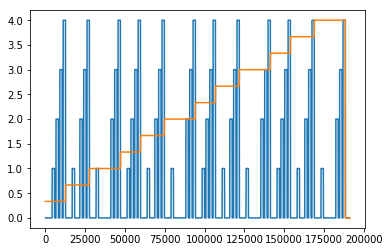

In [8]:
plt.plot(task_index)
plt.plot(epoch_index/3)

In [9]:
ncell = 0
ave_swim = np.zeros((12, 4))
ave_resp_spk = np.zeros((12, 4))
ave_resp_subvolt = np.zeros((12, 4))
task_ind = np.repeat(np.arange(1, 5), 12, axis=0)
for n_epoch in range(1, 13):
    for i in range(1, 5):
        n_ind = (epoch_index==n_epoch) & (task_index==i)
        ave_swim[n_epoch-1, i-1]=frame_swim_tcourse[2,n_ind[:-time_swim]].mean()*100000
        ave_resp_spk[n_epoch-1, i-1]=gauss_rate[ncell,n_ind].mean()*300
        ave_resp_subvolt[n_epoch-1, i-1]= subvolt[ncell,n_ind].mean()*100

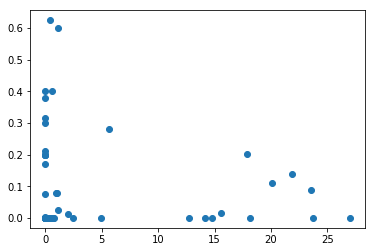

In [10]:
plt.plot(ave_swim.ravel(), ave_resp_spk.ravel(), 'o')

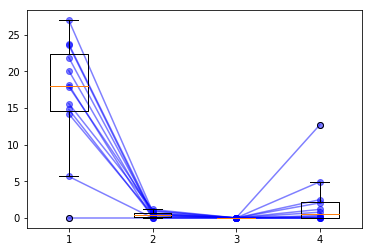

[0.00252617 0.00325181 0.00741744]
[0.20872513 0.23859283 0.87513858]


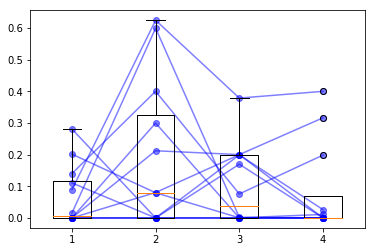

[0.09948088 0.93747292 0.6948866 ]


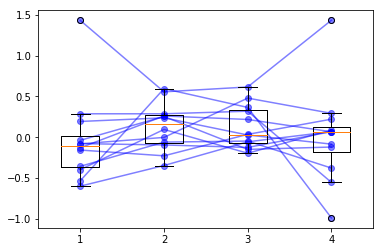

In [11]:
plt.plot(np.arange(1, 5), ave_swim.T, '-ob', alpha=0.5)
plt.boxplot(ave_swim)
plt.show()
print(pair_signrank(ave_swim.T))
plt.plot(np.arange(1, 5), ave_resp_spk.T, '-ob', alpha=0.5)
plt.boxplot(ave_resp_spk)
print(pair_signrank(ave_resp_spk.T))
plt.show()
plt.plot(np.arange(1, 5), ave_resp_subvolt.T, '-ob', alpha=0.5)
plt.boxplot(ave_resp_subvolt)
print(pair_signrank(ave_resp_subvolt.T))
plt.show()

In [12]:
sign_matrix_spk = np.zeros((dff.shape[0], 3))
sign_matrix_subvolt = np.zeros((dff.shape[0], 3))

for ncell in range(dff.shape[0]):
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=gauss_rate[ncell,n_ind].mean()*300
            ave_resp_subvolt[n_epoch-1, i-1]= subvolt[ncell,n_ind].mean()*100
    sign_matrix_spk[ncell] = pair_signrank(ave_resp_spk.T)
    sign_matrix_subvolt[ncell] = pair_signrank(ave_resp_subvolt.T)

In [13]:
print(np.where((sign_matrix_spk[:, 0]<0.05) & (sign_matrix_spk[:, 1]>0.05))[0])
print(np.where((sign_matrix_subvolt[:, 0]<0.05) & (sign_matrix_subvolt[:, 1]>0.05))[0])

[13 19 33 38 39]
[6 8]


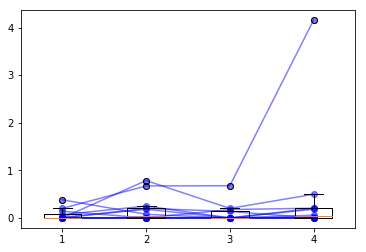

[0.38745517 0.19208376 0.04060921]


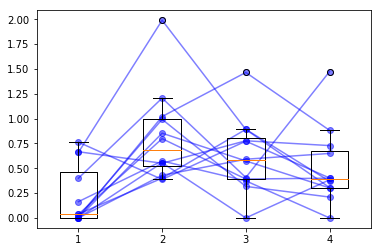

[0.00603956 0.23931654 0.23931654]


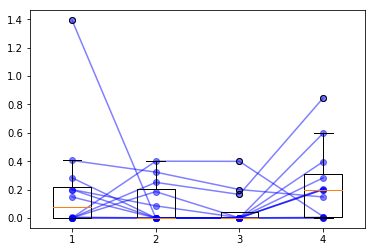

[0.40993686 0.04380499 0.05452053]


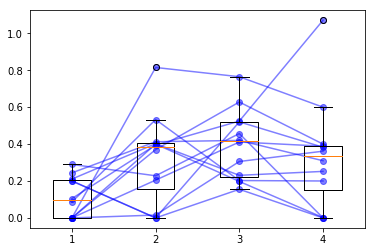

[0.0413894  0.23931654 0.09948088]


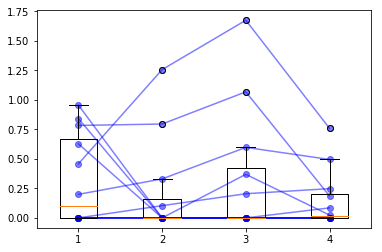

[0.81323886 0.02342434 0.40648344]


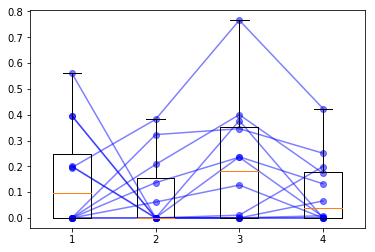

[0.45612585 0.00741744 0.07744209]


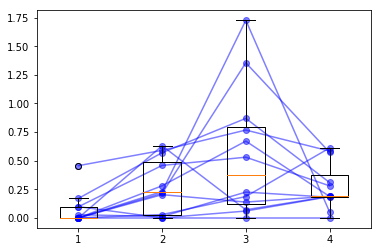

[0.01078745 0.04545875 0.14670764]


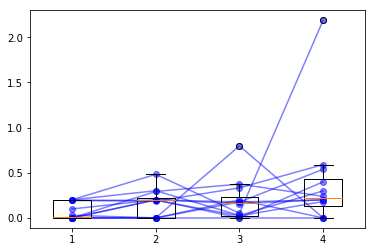

[0.03755939 0.84451927 0.16981051]


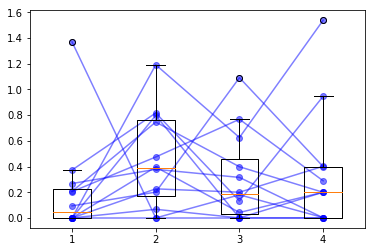

[0.03763288 0.22401538 0.84451927]


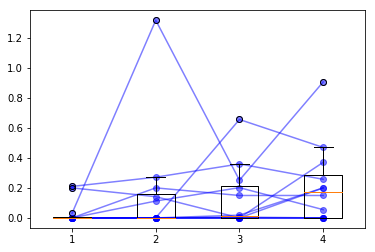

[0.02781486 0.72397982 0.58146268]


In [14]:
sig_spk = np.where((sign_matrix_spk<0.05).sum(axis=1)>0)[0] # np.where((sign_matrix_spk[:, 0]<0.05) & (sign_matrix_spk[:, 1]>0.05))[0]
for ncell in sig_spk:
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=gauss_rate[ncell,n_ind].mean()*300
            ave_resp_subvolt[n_epoch-1, i-1]= subvolt[ncell,n_ind].mean()*100
    plt.plot(np.arange(1, 5), ave_resp_spk.T, '-ob', alpha=0.5)
    plt.boxplot(ave_resp_spk)
    plt.show()
    print(pair_signrank(ave_resp_spk.T))

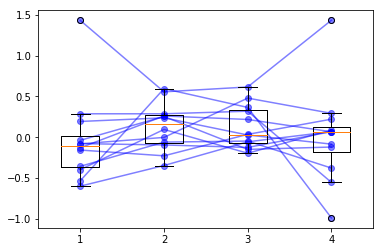

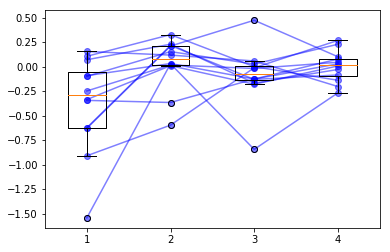

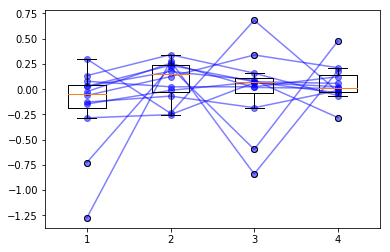

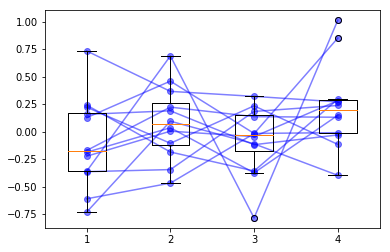

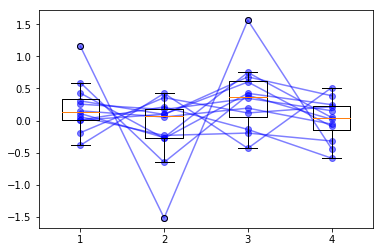

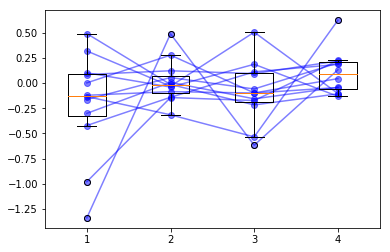

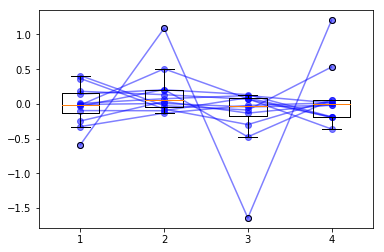

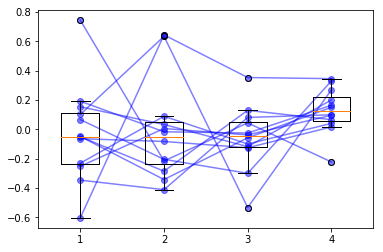

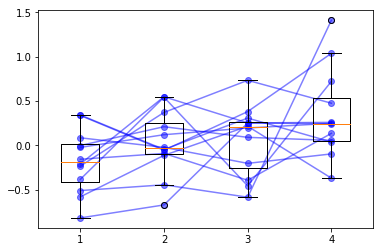

In [15]:
# for ncell in np.where((sign_matrix_subvolt[:, 0]<0.05) & (sign_matrix_subvolt[:, 1]>0.05))[0]:
for ncell in np.where((sign_matrix_subvolt<0.1).sum(axis=1)>0)[0]:
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=gauss_rate[ncell,n_ind].mean()*300
            ave_resp_subvolt[n_epoch-1, i-1]= subvolt[ncell,n_ind].mean()*100
    plt.plot(np.arange(1, 5), ave_resp_subvolt.T, '-ob', alpha=0.5)
    plt.boxplot(ave_resp_subvolt)
    plt.show()

### Run pca on spike

In [16]:
from sklearn.decomposition import PCA
spk_pca = PCA()
spk_pca.fit(np.sqrt(gauss_rate.T))
spk_new = spk_pca.fit_transform(np.sqrt(gauss_rate.T))

In [17]:
sign_matrix_spk_pca = np.zeros((dff.shape[0], 3))
spk_new = spk_new.T
for ncell in range(spk_new.shape[0]):
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=spk_new[ncell,n_ind].mean()*300
    sign_matrix_spk_pca[ncell] = pair_signrank(ave_resp_spk.T)

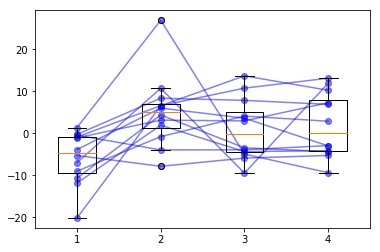

[0.00474177 0.34652171 0.81394535]


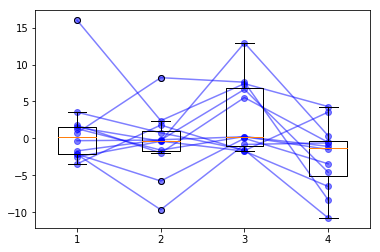

[0.34652171 0.07118923 0.01502234]


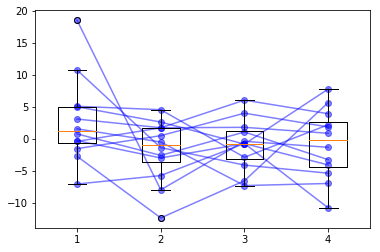

[0.03417047 0.38818641 0.58291955]


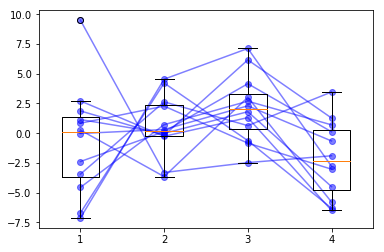

[0.5302846  0.23931654 0.00764908]


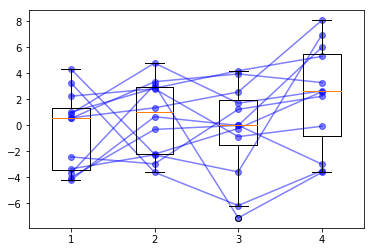

[0.20942676 0.5302846  0.01860293]


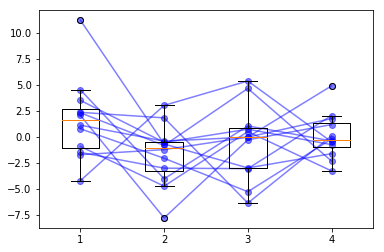

[0.0229091  0.27209518 0.6948866 ]


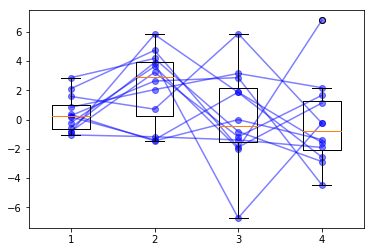

[0.0498602  0.20942676 0.63787018]


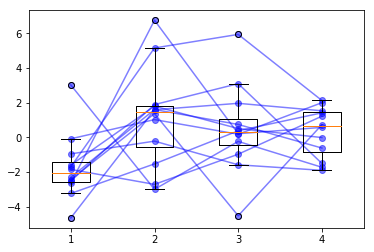

[0.02805612 0.75368372 0.81394535]


In [18]:
sig_spk_pca = np.where((sign_matrix_spk_pca<0.05).sum(axis=1)>0)[0]
for ncell in sig_spk_pca:
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=spk_new[ncell,n_ind].mean()*300
    plt.plot(np.arange(1, 5), ave_resp_spk.T, '-ob', alpha=0.5)
    plt.boxplot(ave_resp_spk)
    plt.show()
    print(pair_signrank(ave_resp_spk.T))

### Run FA on spike

In [19]:
from sklearn.decomposition import FactorAnalysis
num_fa = 15
spk_fa = FactorAnalysis(n_components=num_fa)
spk_fa.fit(np.sqrt(gauss_rate.T))
spk_new_fa = spk_fa.fit_transform(np.sqrt(gauss_rate.T))

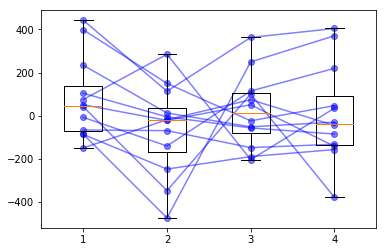

[0.02805612 0.34652171 0.63787018]


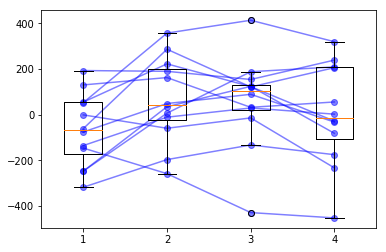

[0.01502234 1.         0.08437944]


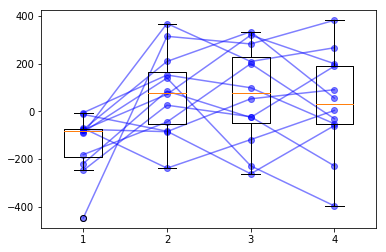

[0.01860293 1.         0.43276758]


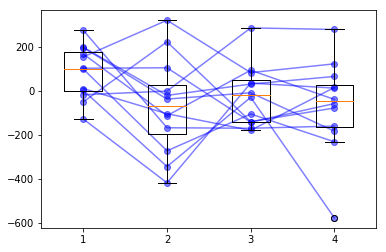

[0.0498602  0.5302846  0.75368372]


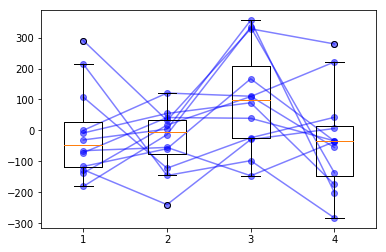

[0.93747292 0.01502234 0.05973902]


In [20]:
sign_matrix_spk_fa = np.zeros((num_fa, 3))
spk_new_fa = spk_new_fa.T
for ncell in range(spk_new_fa.shape[0]):
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=spk_new_fa[ncell,n_ind].mean()*300
    sign_matrix_spk_fa[ncell] = pair_signrank(ave_resp_spk.T)
sig_spk_fa = np.where((sign_matrix_spk_fa<0.05).sum(axis=1)>0)[0]
for ncell in sig_spk_fa:
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_spk[n_epoch-1, i-1]=spk_new_fa[ncell,n_ind].mean()*300
    plt.plot(np.arange(1, 5), ave_resp_spk.T, '-ob', alpha=0.5)
    plt.boxplot(ave_resp_spk)
    plt.show()
    print(pair_signrank(ave_resp_spk.T))

In [21]:
num_neuron = dff.shape[0]
fa_trans = spk_fa.fit_transform(np.eye(num_neuron))

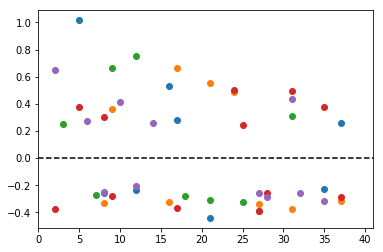

In [22]:
sp_fa_trans = fa_trans[:, sig_spk_fa]
sp_fa_trans[np.abs(sp_fa_trans)<0.2]=0
for n in sp_fa_trans.T:
    plt.plot(np.where(n!=0)[0], n[n!=0], 'o')
plt.plot([0, num_neuron],[0, 0], '--k')
plt.xlim([0, num_neuron])
plt.show()

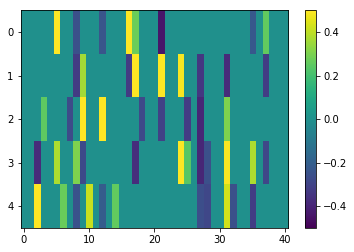

In [23]:
plt.imshow(sp_fa_trans.T, aspect='auto', vmax=0.5, vmin=-0.5)
plt.colorbar()
plt.show()

### Run FA on subvolt

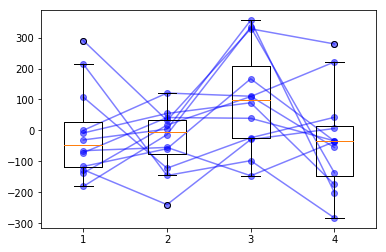

[0.93747292 0.01502234 0.05973902]


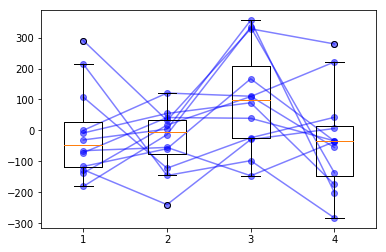

[0.93747292 0.01502234 0.05973902]


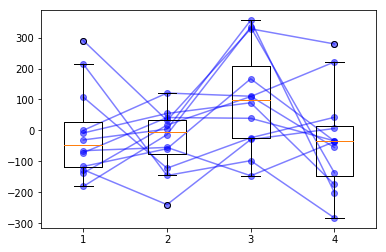

[0.93747292 0.01502234 0.05973902]


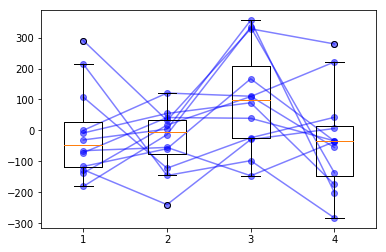

[0.93747292 0.01502234 0.05973902]


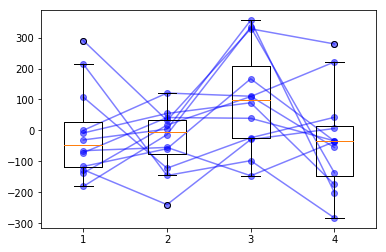

[0.93747292 0.01502234 0.05973902]


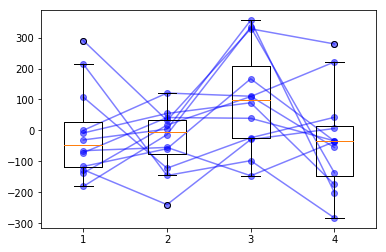

[0.93747292 0.01502234 0.05973902]


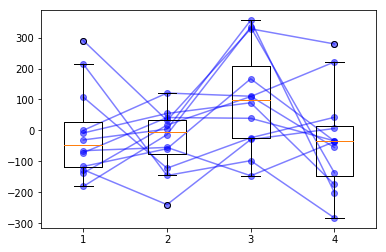

[0.93747292 0.01502234 0.05973902]


In [24]:
from sklearn.decomposition import FactorAnalysis
num_fa = 40
subvolt_fa = FactorAnalysis(n_components=num_fa)
subvolt_fa.fit(subvolt.T)
subvolt_new_fa = subvolt_fa.fit_transform(subvolt.T)

sign_matrix_subvolt_fa = np.zeros((num_fa, 3))
subvolt_new_fa = subvolt_new_fa.T
for ncell in range(subvolt_new_fa.shape[0]):
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_subvolt[n_epoch-1, i-1]= subvolt_new_fa[ncell,n_ind].mean()*100
    sign_matrix_subvolt_fa[ncell] = pair_signrank(ave_resp_subvolt.T)
sig_subvolt_fa = np.where((sign_matrix_subvolt_fa<0.05).sum(axis=1)>0)[0]
for ncell in sig_subvolt_fa:
    for n_epoch in range(1, 13):
        for i in range(1, 5):
            n_ind = (epoch_index==n_epoch) & (task_index==i)
            ave_resp_subvolt[n_epoch-1, i-1]= subvolt_new_fa[ncell,n_ind].mean()*100
    plt.plot(np.arange(1, 5), ave_resp_spk.T, '-ob', alpha=0.5)
    plt.boxplot(ave_resp_spk)
    plt.show()
    print(pair_signrank(ave_resp_spk.T))
    
    
# num_neuron = dff.shape[0]
# fa_trans = spk_fa.fit_transform(np.eye(num_neuron))


# sp_fa_trans = fa_trans[:, sig_spk_fa]
# sp_fa_trans[np.abs(sp_fa_trans)<0.2]=0
# for n in sp_fa_trans.T:
#     plt.plot(np.where(n!=0)[0], n[n!=0], 'o')
# plt.plot([0, num_neuron],[0, 0], '--k')
# plt.xlim([0, num_neuron])
# plt.show()

# plt.imshow(sp_fa_trans.T, aspect='auto', vmax=0.5, vmin=-0.5)
# plt.colorbar()
# plt.show()

In [34]:
sig_subvolt_fa

array([15, 16, 18, 19, 37, 38, 39])

## Spike during swim and memory delay

In [26]:
swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
valid_swim  = (swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250))

In [27]:
swim_ends   = swim_ends[valid_swim]
swim_starts = swim_starts[valid_swim]

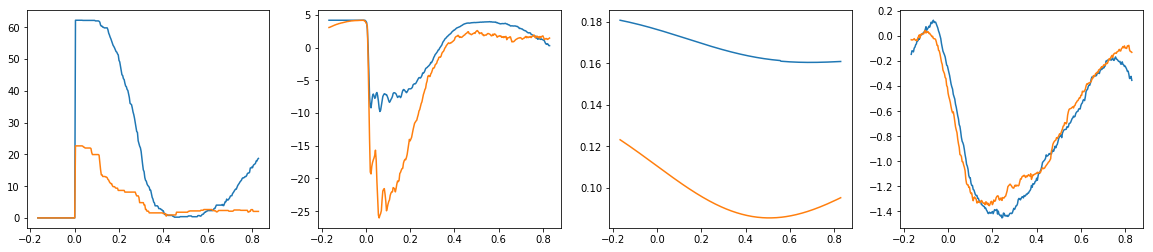

In [28]:
## swim count in each task period
task_period = frame_stimParams[2,swim_starts]
task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
swim_task_index =  task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))
ind_old=0
for s in range(len(swim_starts)):
    ind=swim_task_index[s]
    if (ind>ind_old):
        swim_count[s]=1
        ind_old=ind
    elif (ind==ind_old):
        swim_count[s]=swim_count[s-1]+1
        
## mean swim ptterns\
ncell = 0
ave_swim=np.zeros((len(swim_starts),300))
ave_visu=np.zeros((len(swim_starts),300))
ave_resp_spk=np.zeros((len(swim_starts),300));
ave_resp_subvolt=np.zeros((len(swim_starts),300));
for i in range(len(swim_starts)):
    ave_swim[i,:]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+250)]*100000
    ave_visu[i,:]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+250)]*10000
    ave_resp_spk[i,:]=gauss_rate[ncell,(swim_starts[i]-50):(swim_starts[i]+250)]*300
    ave_resp_subvolt[i,:]= subvolt[ncell,(swim_starts[i]-50):(swim_starts[i]+250)]*100

ave_resp_subvolt -= ave_resp_subvolt[:, :30].mean(axis=1, keepdims=True) # this examine the changes of sub comparing to baseline -- 0.1 sec before swim
plt.figure(figsize=(20, 4))
plt.subplot(1,4,1)
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_swim[task_period==2,:].mean(axis=0))
plt.subplot(1,4,2)
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==1,:].mean(axis=0))
plt.plot(np.arange(-50,250)/300,ave_visu[task_period==2,:].mean(axis=0))
plt.subplot(1,4,3)
plt.plot(np.arange(-50,250)/300,np.mean(ave_resp_spk[task_period==1,:], axis=0))
plt.plot(np.arange(-50,250)/300,np.mean(ave_resp_spk[task_period==2,:], axis=0))
plt.subplot(1,4,4)
plt.plot(np.arange(-50,250)/300,np.mean(ave_resp_subvolt[task_period==1,:], axis=0))
plt.plot(np.arange(-50,250)/300,np.mean(ave_resp_subvolt[task_period==2,:], axis=0))

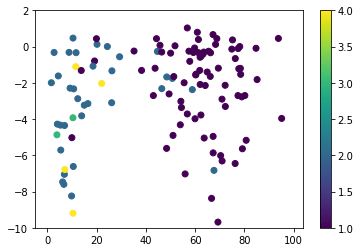

In [29]:
plt.scatter(ave_swim[:, 50:110].mean(axis=1), np.log(ave_resp_spk[:, 50:110].mean(axis=1)+1e-10), c=task_period)
plt.ylim([-10, 2])
plt.colorbar()
plt.show()

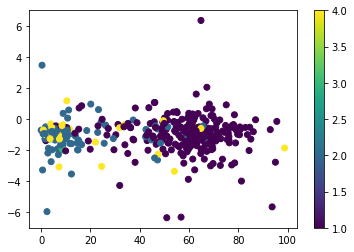

In [30]:
plt.scatter(ave_swim[:, 50:110].mean(axis=1), ave_resp_subvolt[:, 50:110].mean(axis=1), c=task_period)
plt.colorbar()
plt.show()

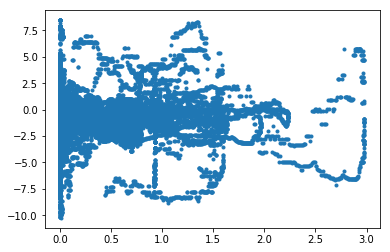

In [31]:
plt.plot(ave_resp_spk.ravel(), ave_resp_subvolt.ravel(),'.')

/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


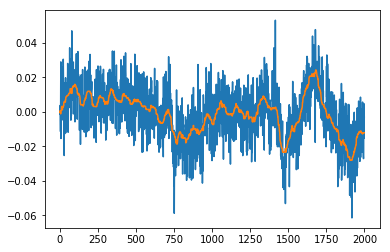

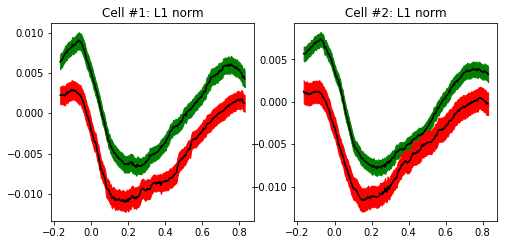

In [32]:


plt.figure(2)
time_range=np.arange(160000,162000)
plt.plot(dff[0,time_range])
plt.plot(subvolt[0,time_range])
# plt.plot(spk[0, time_range]*dff[0,:].max(), '-k')
## mean swim ptterns

stimParam   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4
ntrials     = int(max(frame_stimParams[4,:])-1)

for c in range(2):

    ave_resp_L1  = np.zeros((len(swim_starts),300));
    ave_resp_dff = np.zeros((len(swim_starts),300));

    for i in range(len(swim_starts)):
        ave_resp_L1[i,:]  = subvolt[c,(swim_starts[i]-50):(swim_starts[i]+250)]
#         ave_resp_dff[i,:] = smooth(dff[c,(swim_starts[i]-50):(swim_starts[i]+250)],short_kernel)
    
#     ave_resp_L1 -= ave_resp_L1[:,:30].mean(axis=1)[:,None]
#     ave_resp_dff -= ave_resp_dff[:,:30].mean(axis=1)[:,None]
    
        
    plt.figure(3,figsize=(8,8)) # Swim average during low gain (green) and high gain (red)
    
    sub_ave1_L1 = ave_resp_L1[task_period==1,:].mean(axis=0) ## events during low gain
    sub_err1_L1 = ave_resp_L1[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==1,:].shape[0])
    sub_ave2_L1 = ave_resp_L1[task_period==2,:].mean(axis=0) ## events during high gain
    sub_err2_L1 = ave_resp_L1[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_L1[task_period==2,:].shape[0])
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave1_L1-sub_err1_L1, sub_ave1_L1+sub_err1_L1,color='g')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave1_L1,'k')
    plt.subplot(2,2,c+1).fill_between(np.arange(-50,250)/300,sub_ave2_L1-sub_err2_L1, sub_ave2_L1+sub_err2_L1,color='r')
    plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,sub_ave2_L1,'k')
    plt.title('Cell #'+str(c+1)+': L1 norm')
              
#     sub_ave1_df = ave_resp_dff[task_period==1,:].mean(axis=0) ## events during low gain
#     sub_err1_df = ave_resp_dff[task_period==1,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==1,:].shape[0])
#     sub_ave2_df = ave_resp_dff[task_period==2,:].mean(axis=0) ## events during high gain
#     sub_err2_df = ave_resp_dff[task_period==2,:].std(axis=0)/np.sqrt(ave_resp_dff[task_period==2,:].shape[0])
#     plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave1_df-sub_err1_df, sub_ave1_df+sub_err1_df,color='g')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave1_df,'k')
#     plt.subplot(2,2,c+3).fill_between(np.arange(-50,250)/300,sub_ave2_df-sub_err2_df, sub_ave2_df+sub_err2_df,color='r')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,sub_ave2_df,'k')
#     plt.title('Cell #'+str(c+1)+': Gauss smooth')
    
#     plt.figure(4,figsize=(8,8)) # Swim count-dependent average (k=low gain, b=1-3 bout, g=4-6 bouts, r=7-9 bouts)
    
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[task_period==1,:].mean(axis=0),'k')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
#     plt.subplot(2,2,c+1).plot(np.arange(-50,250)/300,ave_resp_L1[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
#     plt.title('Cell #'+str(c+1)+': L1 norm')
              
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[task_period==1,:].mean(axis=0),'k')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=3)),:].mean(axis=0),'b')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=6) & (swim_count>=3)),:].mean(axis=0),'g')
#     plt.subplot(2,2,c+3).plot(np.arange(-50,250)/300,ave_resp_dff[((task_period==2) & (swim_count<=9) & (swim_count>=7)),:].mean(axis=0),'r')
#     plt.title('Cell #'+str(c+1)+': Gauss smooth')

In [33]:
ave_resp_L1.shape

(349, 300)